In [ ]:
import copy
import numpy as np
import sklearn

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import hstack
from sklearn.preprocessing import StandardScaler
import datetime
import time
import joblib
from datetime import timedelta, date
import tensorflow as tf
import tensorflow.keras
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
import time
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
import time
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense


from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
import errno
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter
import imblearn
import collections
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot


In [ ]:
import pandas as pd

def load_data_south_indian(url):
    """
    Load and preprocess data for South Indian region.

    Parameters:
    - url (str): URL or file path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame with a 'category' column.
    """
    # Load data from CSV
    df = pd.read_csv(url)

    # Add a 'category' column based on speed ranges
    df['category'] = df['Speed(knots)'].apply(lambda x:
        0 if x <= 33 else
        1 if 34 <= x <= 47 else
        2 if 48 <= x <= 63 else
        3 if 64 <= x <= 89 else
        4 if 90 <= x <= 115 else
        5
    )

    return df

def load_data_south_pacific(url):
    """
    Load and preprocess data for South Pacific region.

    Parameters:
    - url (str): URL or file path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame with a 'category' column.
    """
    # Load data from CSV
    df = pd.read_csv(url)

    # Add a 'category' column based on speed ranges
    df['category'] = df['Speed(knots)'].apply(lambda x:
        0 if x <= 33 else
        1 if 34 <= x <= 47 else
        2 if 48 <= x <= 63 else
        3 if 64 <= x <= 85 else
        4 if 86 <= x <= 107 else
        5
    )

    return df

In [ ]:
ocean = 'south_pacific'

# Display the selected ocean
print(f"Selected ocean: {ocean}")

# Set the data URL and function based on the selected ocean
if ocean == 'south_indian':
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_indian_hurricane.csv'
    data_loading_function = load_data_south_indian
    hot_encoded_result_file_name = 'south_indian'
    category_result_file_name = 'roc_data_south_indian'
else:
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv'
    data_loading_function = load_data_south_pacific
    hot_encoded_result_file_name = 'south_pacific'
    category_result_file_name = 'roc_data_south_pacific'

# Display the data URL for verification
print(f"Data URL: {url_data}")

# Display the result file names
print(f"Hot-encoded result file name: {hot_encoded_result_file_name}")
print(f"Category result file name: {category_result_file_name}")


Selected ocean: south_pacific
Data URL: https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv
Hot-encoded result file name: south_pacific
Category result file name: roc_data_south_pacific


In [ ]:
# Load data using the specified function and URL
df = data_loading_function(url_data)

df['Lat'] = df['Lat'].apply(lambda x: -int(x[:-1]) * 0.1 if x.endswith('N') else int(x[:-1]) * 0.1 if x.endswith('S') else 0)
df['Lon'] = df['Lon'].apply(lambda x: -int(x[:-1]) * 0.1 if x.endswith('W') else int(x[:-1]) * 0.1 if x.endswith('E') else 0)

# Extract 'Speed(knots)' and 'category' columns as lists
speed = df['Speed(knots)'].tolist()
categories = df['category'].tolist()
latitude = df['Lat'].tolist()
longitude = df['Lon'].tolist()

# Display the first few rows of the DataFrame
df_head = df.head()
print("DataFrame Head:")
print(df_head)



DataFrame Head:
  Basin  No. of Cycl        Time     V5  V6   Lat    Lon  Speed(knots)  \
0    SP           14  1982012518   BEST   0  18.0  154.1            25   
1    SP           14  1982012600   BEST   0  19.1  154.8            25   
2    SP           14  1982012606   BEST   0  19.7  155.7            25   
3    SP           14  1982012612   BEST   0  19.9  156.7            30   
4    SP           14  1982012618   BEST   0  20.1  157.8            35   

   lat_tenth  lon_tenth  category  
0       18.0      154.1         0  
1       19.1      154.8         0  
2       19.7      155.7         0  
3       19.9      156.7         0  
4       20.1      157.8         1  


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def split_sequence(sequences, n_steps_in, n_steps_out):
    """
    Split multivariate sequences into input and output parts.

    Parameters:
    - sequences (numpy.ndarray): Multivariate time series data.
    - n_steps_in (int): Number of input time steps.
    - n_steps_out (int): Number of output time steps.

    Returns:
    - tuple: Input sequences (X) and output sequences (y) as numpy arrays.
    """
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def uni_split_sequence(sequence, n_steps):
    """
    Split univariate sequence into input and output parts.

    Parameters:
    - sequence (list): Univariate time series data.
    - n_steps (int): Number of input time steps.

    Returns:
    - tuple: Input sequences (X) and output sequences (y) as numpy arrays.
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def rmse(pred, actual):
    """
    Calculate the Root Mean Squared Error (RMSE) between two arrays.

    Parameters:
    - pred (numpy.ndarray): Predicted values.
    - actual (numpy.ndarray): Actual values.

    Returns:
    - float: Root Mean Squared Error.
    """
    return np.sqrt(((pred - actual) ** 2).mean())

def categorical(pred, actual):
    """
    Compute classification metrics for categorical values.

    Parameters:
    - pred (numpy.ndarray): Predicted categorical values.
    - actual (numpy.ndarray): Actual categorical values.

    Returns:
    - tuple: Accuracy, AUC, Confusion Matrix, Precision, Recall, F1 Score.
    """
    cm = confusion_matrix(pred, actual)
    acc = accuracy_score(actual, pred, normalize=True, sample_weight=None)
    ps1 = precision_score(pred, actual, average='micro')
    rs1 = recall_score(pred, actual, average='micro')
    f11 = f1_score(pred, actual, average='micro')
    auc = roc_auc_score(actual, pred)
    return acc, auc, cm, ps1, rs1, f11

def make_confusion_matrix_chart(cf_matrix_test, cmap='Blues', annot_kws=None):
    """
    Generate and display a heatmap-style confusion matrix chart.

    Parameters:
    - cf_matrix_test (numpy.ndarray): Confusion matrix.
    - cmap (str): Colormap for the heatmap.
    - annot_kws (dict): Additional keyword arguments for annotation customization.

    Returns:
    - None
    """
    # Set up the figure and axes
    plt.figure(figsize=(12, 6))

    # Customize the heatmap using seaborn
    sns.heatmap(cf_matrix_test, annot=True, cmap=cmap,
                yticklabels=['0', '1'], xticklabels=['0', '1'],
                fmt='g', annot_kws=annot_kws)

    # Customize axis labels and title
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title('Confusion Matrix - Test Data')

    return None

In [ ]:
# Define whether it's a univariate or multivariate case
univariate = True  # If False, it's a multivariate case

# Define sequence and time step parameters
n_steps_in = 6
n_seq = 2
n_steps_out = 1

# Define the number of features for input and output
n_features_in = 1  # Speed
n_features_out = 2  # One-hot encoding of category

# Define the number of hidden layers in the model
hidden_layers = 50

# Define training parameters
epochs = 100
No_exp = 30 # Number of experiments

# Display the configuration
print("Configuration:")
print(f"Univariate: {univariate}")
print(f"Number of Input Time Steps: {n_steps_in}")
print(f"Number of Input Sequences: {n_seq}")
print(f"Number of Output Time Steps: {n_steps_out}")
print(f"Number of Input Features: {n_features_in}")
print(f"Number of Output Features: {n_features_out}")
print(f"Number of Hidden Layers: {hidden_layers}")
print(f"Epochs: {epochs}")
print(f"Number of Experiments: {No_exp}")

Configuration:
Univariate: True
Number of Input Time Steps: 6
Number of Input Sequences: 2
Number of Output Time Steps: 1
Number of Input Features: 1
Number of Output Features: 2
Number of Hidden Layers: 50
Epochs: 100
Number of Experiments: 30


In [ ]:
# Initialize variables
cyclone_id = df['No. of Cycl'][0]
X = []
Y = []
start_index = 0
end_index = 0

# Iterate through the DataFrame
for i in range(1, df.shape[0]):
    # Check if the cyclone ID is the same as the previous row
    if df['No. of Cycl'][i] == cyclone_id:
        end_index += 1
    else:
        # Split the sequence and append to X and Y
        x, y = uni_split_sequence(speed[start_index:end_index + 1], n_steps_in)
        X.append(x)
        Y.append(y)

        # Update start and end indices for the new cyclone
        cyclone_id = df['No. of Cycl'][i]
        start_index = i
        end_index = i

    # Check if it's the last row of the DataFrame
    if i == df.shape[0] - 1:
        # Split the sequence and append to X and Y
        x, y = uni_split_sequence(speed[start_index:end_index + 1], n_steps_in)
        X.append(x)
        Y.append(y)
print(X[0])


[[25 25 25 30 35 40]
 [25 25 30 35 40 40]
 [25 30 35 40 40 40]
 [30 35 40 40 40 40]
 [35 40 40 40 40 40]
 [40 40 40 40 40 40]
 [40 40 40 40 40 40]
 [40 40 40 40 40 40]
 [40 40 40 40 40 40]
 [40 40 40 40 40 35]
 [40 40 40 40 35 35]
 [40 40 40 35 35 40]
 [40 40 35 35 40 40]
 [40 35 35 40 40 40]
 [35 35 40 40 40 40]
 [35 40 40 40 40 40]
 [40 40 40 40 40 35]
 [40 40 40 40 35 35]
 [40 40 40 35 35 40]
 [40 40 35 35 40 45]
 [40 35 35 40 45 45]
 [35 35 40 45 45 50]
 [35 40 45 45 50 50]
 [40 45 45 50 50 55]
 [45 45 50 50 55 55]
 [45 50 50 55 55 50]
 [50 50 55 55 50 55]
 [50 55 55 50 55 60]
 [55 55 50 55 60 65]
 [55 50 55 60 65 65]
 [50 55 60 65 65 65]
 [55 60 65 65 65 60]
 [60 65 65 65 60 50]
 [65 65 65 60 50 45]
 [65 65 60 50 45 45]
 [65 60 50 45 45 40]
 [60 50 45 45 40 40]
 [50 45 45 40 40 35]
 [45 45 40 40 35 35]
 [45 40 40 35 35 30]
 [40 40 35 35 30 30]]


In [ ]:
# Initialize variables
cyclone_id = df['No. of Cycl'][0]
X_lat = []
Y_lat = []
start_index_lat = 0
end_index_lat = 0

# Iterate through the DataFrame
for i in range(1, df.shape[0]):
    # Check if the cyclone ID is the same as the previous row
    if df['No. of Cycl'][i] == cyclone_id:
        end_index_lat += 1
    else:
        # Split the sequence and append to X_lat and Y_lat
        x_lat, y_lat = uni_split_sequence(latitude[start_index_lat:end_index_lat + 1], n_steps_in)
        X_lat.append(x_lat)
        Y_lat.append(y_lat)

        # Update start and end indices for the new cyclone
        cyclone_id = df['No. of Cycl'][i]
        start_index_lat = i
        end_index_lat = i

    # Check if it's the last row of the DataFrame
    if i == df.shape[0] - 1:
        # Split the sequence and append to X_lat and Y_lat
        x_lat, y_lat = uni_split_sequence(latitude[start_index_lat:end_index_lat + 1], n_steps_in)
        X_lat.append(x_lat)
        Y_lat.append(y_lat)


In [ ]:
# Initialize variables
cyclone_id = df['No. of Cycl'][0]
X_lon = []
Y_lon = []
start_index_lon = 0
end_index_lon = 0

# Iterate through the DataFrame
for i in range(1, df.shape[0]):
    # Check if the cyclone ID is the same as the previous row
    if df['No. of Cycl'][i] == cyclone_id:
        end_index_lon += 1
    else:
        # Split the sequence and append to X_lon and Y_lon
        x_lon, y_lon = uni_split_sequence(longitude[start_index_lon:end_index_lon + 1], n_steps_in)
        X_lon.append(x_lon)
        Y_lon.append(y_lon)

        # Update start and end indices for the new cyclone
        cyclone_id = df['No. of Cycl'][i]
        start_index_lon = i
        end_index_lon = i

    # Check if it's the last row of the DataFrame
    if i == df.shape[0] - 1:
        # Split the sequence and append to X_lon and Y_lon
        x_lon, y_lon = uni_split_sequence(longitude[start_index_lon:end_index_lon + 1], n_steps_in)
        X_lon.append(x_lon)
        Y_lon.append(y_lon)

In [ ]:
# Print the initial lengths of X and Y
print(len(X), len(Y))
# Flattening X and Y
X = [item for sublist in X for item in sublist]
Y = [item for sublist in Y for item in sublist]
#Print lengths of X and Y after flattening
print(len(X), len(Y))
print(X[0], Y[0], X[1], Y[1])
print(speed[:10])

391 391
9697 9697
[25 25 25 30 35 40] 40 [25 25 30 35 40 40] 40
[25, 25, 25, 30, 35, 40, 40, 40, 40, 40]


In [ ]:
# Print the initial lengths of X_lat and Y_lat
print(len(X_lat), len(Y_lat))

# Flattening X_lat and Y_lat
X_lat = [item for sublist in X_lat for item in sublist]
Y_lat = [item for sublist in Y_lat for item in sublist]

# Print lengths of X_lat and Y_lat after flattening
print(len(X_lat), len(Y_lat))
print(X_lat[0], Y_lat[0], X_lat[1], Y_lat[1])
print(latitude[:10])

391 391
9697 9697
[18.  19.1 19.7 19.9 20.1 20.4] 20.700000000000003 [19.1 19.7 19.9 20.1 20.4 20.7] 21.0
[18.0, 19.1, 19.700000000000003, 19.900000000000002, 20.1, 20.400000000000002, 20.700000000000003, 21.0, 21.200000000000003, 21.5]


In [ ]:
# Print the initial lengths of X_lat and Y_lat
print(len(X_lon), len(Y_lon))

# Flattening X_lat and Y_lat
X_lon = [item for sublist in X_lon for item in sublist]
Y_lon = [item for sublist in Y_lon for item in sublist]

# Print lengths of X_lat and Y_lat after flattening
print(len(X_lon), len(Y_lon))
print(X_lon[0], Y_lon[0], X_lon[1], Y_lon[1])
print(longitude[:10])

391 391
9697 9697
[154.1 154.8 155.7 156.7 157.8 158.6] 159.10000000000002 [154.8 155.7 156.7 157.8 158.6 159.1] 159.5
[154.10000000000002, 154.8, 155.70000000000002, 156.70000000000002, 157.8, 158.60000000000002, 159.10000000000002, 159.5, 159.60000000000002, 159.5]


In [ ]:
# Initialize 'intensify_y' with zeros
intensify_y = [0] * len(X)

# Iterate through each row in X and update intensify_y based on the condition
for i in range(len(X)):
    for j in range(len(X[0]) - 4, len(X[0])):
        if (Y[i] - X[i][j]) >= 30:
            intensify_y[i] = 1
            break

print(len(intensify_y))

# Use 'intensify_y' as the updated target variable
Y = intensify_y
Y_lon = intensify_y
Y_lat = intensify_y


9697


In [ ]:
# Calculate the training limit as 75% of the total length of X
train_limit = int(len(X) * 0.75)

# Display the calculated training limit
print("Training Limit:", train_limit)

Training Limit: 7272


In [ ]:
# Calculate the training limit based on latitude
train_limit_lat = int(len(X_lat) * 0.75)

# Display the calculated training limit for latitude
print("Training Limit (Latitude):", train_limit_lat)


Training Limit (Latitude): 7272


In [ ]:
# Calculate the training limit based on longitude
train_limit_lon = int(len(X_lon) * 0.75)

# Display the calculated training limit for longitude
print("Training Limit (Longitude):", train_limit_lon)

Training Limit (Longitude): 7272


In [ ]:
# Extract test data for evaluation
test_X_original = X[train_limit + 1:]
test_Y_original = Y[train_limit + 1:]

# Display the lengths of the datasets
print("Length of X:", len(X))
print("Length of Y:", len(Y))
print("Length of Test X (for evaluation):", len(test_X_original))
print("Length of Test Y (for evaluation):", len(test_Y_original))


Length of X: 9697
Length of Y: 9697
Length of Test X (for evaluation): 2424
Length of Test Y (for evaluation): 2424


In [ ]:
# Extract test data for evaluation based on latitude
test_X_original_lat = X_lat[train_limit_lat + 1:]
test_Y_original_lat = Y_lat[train_limit_lat + 1:]

# Display the lengths of the datasets for latitude
print("Length of X (Latitude):", len(X_lat))
print("Length of Y (Latitude):", len(Y_lat))
print("Length of Test X (for evaluation, Latitude):", len(test_X_original_lat))
print("Length of Test Y (for evaluation, Latitude):", len(test_Y_original_lat))

Length of X (Latitude): 9697
Length of Y (Latitude): 9697
Length of Test X (for evaluation, Latitude): 2424
Length of Test Y (for evaluation, Latitude): 2424


In [ ]:
# Extract test data for evaluation based on longitude
test_X_original_lon = X_lon[train_limit_lon + 1:]
test_Y_original_lon = Y_lon[train_limit_lon + 1:]

# Display the lengths of the datasets for longitude
print("Length of X (Longitude):", len(X_lon))
print("Length of Y (Longitude):", len(Y_lon))
print("Length of Test X (for evaluation, Longitude):", len(test_X_original_lon))
print("Length of Test Y (for evaluation, Longitude):", len(test_Y_original_lon))


Length of X (Longitude): 9697
Length of Y (Longitude): 9697
Length of Test X (for evaluation, Longitude): 2424
Length of Test Y (for evaluation, Longitude): 2424


In [ ]:
# Normalize the sequences in X using Min-Max scaling
X = MinMaxScaler().fit_transform(np.asarray(X))
# Apply MinMaxScaler to latitude
X_lat = MinMaxScaler().fit_transform(np.asarray(X_lat))
# Apply MinMaxScaler to longitude
X_lon = MinMaxScaler().fit_transform(np.asarray(X_lon))


In [ ]:
# Save the original X (speed) values before splitting
speed_x = X
test_X = X[train_limit+1:]
test_X = np.asarray(test_X).astype(float)
test_Y = Y[train_limit+1:]
X = X[:train_limit]
X = np.asarray(X).astype(float)
Y = Y[:train_limit]
print(test_Y)
len(X), len(Y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

(7272, 7272)

In [ ]:
# Assign latitude data to latitude_x
latitude_x = X_lat

# Extract test data for latitude
test_X_lat = X_lat[train_limit_lat + 1:]
test_X_lat = np.asarray(test_X_lat).astype(float)
test_Y_lat = Y_lat[train_limit_lat + 1:]
X_lat = X_lat[:train_limit_lat]
X_lat = np.asarray(X_lat).astype(float)
Y_lat = Y_lat[:train_limit_lat]
test_Y_lat
len(X_lat), len(Y_lat)

(7272, 7272)

In [ ]:
# Assign latitude data to latitude_x
longitude_x = X_lon

# Extract test data for latitude
test_X_lon = X_lon[train_limit_lon + 1:]
test_X_lon = np.asarray(test_X_lon).astype(float)
test_Y_lon = Y_lon[train_limit_lon + 1:]
X_lon = X_lon[:train_limit_lat]
X_lon = np.asarray(X_lon).astype(float)
Y_lon = Y_lon[:train_limit_lon]
test_Y_lon
len(X_lon), len(Y_lon)


(7272, 7272)

In [ ]:
# Calculate the class distribution for training and test data
counter_train = Counter(Y)
counter_test = Counter(test_Y)

# Display the class distribution for training data
print("Class Distribution - Training Data:")
print(counter_train)

# Display the class distribution for test data
print("\nClass Distribution - Test Data:")
print(counter_test)

Class Distribution - Training Data:
Counter({0: 6897, 1: 375})

Class Distribution - Test Data:
Counter({0: 2396, 1: 28})


In [ ]:
# Calculate the class distribution for training and test data for latitude
counter_train_lat = Counter(Y_lat)
counter_test_lat = Counter(test_Y_lat)

# Display the class distribution for training data for latitude
print("Class Distribution - Training Data (Latitude):")
print(counter_train_lat)

# Display the class distribution for test data for latitude
print("\nClass Distribution - Test Data (Latitude):")
print(counter_test_lat)



Class Distribution - Training Data (Latitude):
Counter({0: 6897, 1: 375})

Class Distribution - Test Data (Latitude):
Counter({0: 2396, 1: 28})


In [ ]:
# Calculate the class distribution for training and test data for longitude
counter_train_lon = Counter(Y_lon)
counter_test_lon = Counter(test_Y_lon)

# Display the class distribution for training data for longitude
print("Class Distribution - Training Data (Longitude):")
print(counter_train_lon)

# Display the class distribution for test data for longitude
print("\nClass Distribution - Test Data (Longitude):")
print(counter_test_lon)

Class Distribution - Training Data (Longitude):
Counter({0: 6897, 1: 375})

Class Distribution - Test Data (Longitude):
Counter({0: 2396, 1: 28})


In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, concatenate


def stacked_lstm(n_steps_in, n_features_in):
    input_1 = Input(shape=(n_steps_in, n_features_in))
    lstm_1 = LSTM(50, activation='relu')(input_1)

    input_2 = Input(shape=(n_steps_in, n_features_in))
    lstm_2 = LSTM(50, activation='relu')(input_2)

    input_3 = Input(shape=(n_steps_in, n_features_in))
    lstm_3 = LSTM(50, activation='relu')(input_3)

    concat = concatenate([lstm_1, lstm_2, lstm_3])
    output = Dense(2, activation='softmax')(concat)

    model = Model(inputs=[input_1, input_2, input_3], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
n_features_in_speed = 1
n_features_in_latitude = 1
n_features_in_longitude = 1


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
import time

def lstm(stacked_model,  x_train_lat, x_train_lon, x_train, y_train, x_test_lat, x_test_lon, x_test, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs):
    # Initialize arrays to store accuracy metrics
    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)

    # Initialize arrays to store predictions and classification reports
    y_predicttest_allruns = np.zeros([Num_Exp, x_test_lat.shape[0], y_test.shape[1]])
    Best_f1 = 0  # Initialize the best F1 score
    Best_Predict_Test = 0

    # Extract the actual classes from one-hot encoded vectors for both test and train sets
    act_test = [y_test[i].argmax() for i in range(y_test.shape[0])]
    act_train = [y_train[i].argmax() for i in range(y_train.shape[0])]

    # Initialize dictionaries to store classification reports
    Best_report_train = dict()
    Best_report_test = dict()
    all_report_train = dict()
    all_report_test = dict()

    # Loop through experiment runs
    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")

        # Fit the stacked model
        stacked_model.fit([x_train_lat, x_train_lon, x_train], y_train, epochs=Epochs, batch_size=10, verbose=1, shuffle=False)
        y_predicttrain = stacked_model.predict([x_train_lat, x_train_lon, x_train])
        y_predicttest = stacked_model.predict([x_test_lat, x_test_lon, x_test])
        print(y_predicttrain[0])
        print(y_predicttest[0])

        # Extract predicted classes from one-hot encoded vectors
        pred_test = [y_predicttest[i].argmax() for i in range(y_predicttest.shape[0])]
        pred_train = [y_predicttrain[i].argmax() for i in range(y_predicttrain.shape[0])]

        c = 0
        for i in pred_test:
          if(i==1):
            c = c+1
        print(c)
        d = 0
        for i in pred_train:
          if(i==1):
            d = d+1
        print(d)


        # Generate classification reports
        report_train = classification_report(act_train, pred_train, labels=[0, 1], output_dict=True)
        report_test = classification_report(act_test, pred_test, labels=[0, 1], output_dict=True)

        # Store classification reports in dictionaries
        all_report_train[run] = report_train
        all_report_test[run] = report_test

        # Calculate F1-score for the test set
        train_acc[run] = report_train['1']['f1-score']
        test_acc[run] = report_test['1']['f1-score']
        print("train acc: ", train_acc[run])
        print("test acc: ", test_acc[run])

    # Update the best F1 score and associated predictions and reports
    if test_acc[run] > Best_f1:
        Best_f1 = test_acc[run]
        Best_Predict_Test = y_predicttest
        Best_report_train, Best_report_test = report_train, report_test

    # Save the trained model (assuming you have the 'ocean' variable)
    stacked_model.save("model_" + ocean + "_stacked_lstm.h5")

    # Calculate standard deviations of train and test accuracies
    train_std = np.std(train_acc)
    test_std = np.std(test_acc)

    # Display experiment summary
    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    print("F1 scores for test data: ", test_acc)
    print("Mean: ", np.mean(test_acc), "Std Dev: ", test_std)

    # Return relevant information
    return train_acc, test_acc, train_std, test_std, Best_Predict_Test, y_predicttrain, y_predicttest, all_report_train, all_report_test


In [ ]:
# Create a random permutation of indices for shuffling
# idx = np.random.permutation(len(X_smote))
idx = np.random.permutation(len(X))
print(len(idx))

# Initialize lists to store shuffled data
x_shuffled = []
y_shuffled = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    # x_shuffled.append(X_smote[i])
    # y_shuffled.append(Y_smote[i])
    x_shuffled.append(X[i])
    y_shuffled.append(Y[i])


7272


In [ ]:
# Create a random permutation of indices for shuffling
# idx = np.random.permutation(len(X_smote))
idx = np.random.permutation(len(X_lat))
print(len(idx))

# Initialize lists to store shuffled data
x_shuffled_lat = []
y_shuffled_lat = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    # x_shuffled.append(X_smote[i])
    # y_shuffled.append(Y_smote[i])
    x_shuffled_lat.append(X_lat[i])
    y_shuffled_lat.append(Y_lat[i])


7272


In [ ]:
# Create a random permutation of indices for shuffling
# idx = np.random.permutation(len(X_smote))
idx = np.random.permutation(len(X_lon))
print(len(idx))

# Initialize lists to store shuffled data
x_shuffled_lon = []
y_shuffled_lon = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    # x_shuffled.append(X_smote[i])
    # y_shuffled.append(Y_smote[i])
    x_shuffled_lon.append(X_lon[i])
    y_shuffled_lon.append(Y_lon[i])

7272


In [ ]:
# Convert the shuffled labels to one-hot encoded format for training data
Y_hot_encoded_train = np.asarray(to_categorical(y_shuffled))

# Convert the test labels to one-hot encoded format
Y_hot_encoded_test = np.asarray(to_categorical(test_Y))

# Print the shapes of the one-hot encoded training and test labels
print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)




(7272, 2) (2424, 2)


In [ ]:
Y_hot_encoded_train[0]

array([1., 0.])

In [ ]:
Y_hot_encoded_train_lat = np.asarray(to_categorical(y_shuffled_lat))

# Convert the test labels to one-hot encoded format
Y_hot_encoded_test_lat = np.asarray(to_categorical(test_Y_lat))

# Print the shapes of the one-hot encoded training and test labels
print(Y_hot_encoded_train_lat.shape, Y_hot_encoded_test_lat.shape)


(7272, 2) (2424, 2)


In [ ]:
Y_hot_encoded_train_lon = np.asarray(to_categorical(y_shuffled_lon))

# Convert the test labels to one-hot encoded format
Y_hot_encoded_test_lon = np.asarray(to_categorical(test_Y_lon))

# Print the shapes of the one-hot encoded training and test labels
print(Y_hot_encoded_train_lon.shape, Y_hot_encoded_test_lon.shape)


(7272, 2) (2424, 2)


In [ ]:
predictions_train = dict()
actual_train = dict()
predictions_test = dict()
actual_test = dict()
metrics_train = dict()
metrics_test = dict()
test_acc_all = dict()
test_stddev = dict()

In [ ]:
# Loop over different values of n_steps_out (in this case, only 1)
for j in range(1):
    # Initialize dictionaries to store results for the ensemble model
    predictions_train_per_step = dict()
    actual_train_per_step = dict()
    predictions_test_per_step = dict()
    actual_test_per_step = dict()
    metrics_train_per_step = dict()
    metrics_test_per_step = dict()
    test_acc_per_step = dict()
    test_stddev_per_step = dict()
    n_steps_out = j + 1

    print('---------------------------------------------------------')
    print('Number of steps out:', n_steps_out)

    # Reshape data based on the ensemble model type
    x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
    x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)

    x_train_lat, y_train_lat = np.asarray(x_shuffled_lat), np.asarray(Y_hot_encoded_train_lat)
    x_test_lat, y_test_lat = np.asarray(test_X_lat), np.asarray(Y_hot_encoded_test_lat)

    x_train_lon, y_train_lon = np.asarray(x_shuffled_lon), np.asarray(Y_hot_encoded_train_lon)
    x_test_lon, y_test_lon = np.asarray(test_X_lon), np.asarray(Y_hot_encoded_test_lon)

    # Call ensemble_lstm to create the ensemble model

    stacked_model = stacked_lstm(n_steps_in, n_features_in)
    # Call the lstm function with the ensemble model and retrieve results
    train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test = lstm(stacked_model,  x_train_lat, x_train_lon, x_train, y_train, x_test_lat, x_test_lon, x_test, y_test, No_exp, n_steps_in, n_steps_out, epochs)

    # Store results in respective dictionaries
    predictions_train_per_step['ensemble'] = Best_Predict_Test
    actual_train_per_step['ensemble'] = y_train
    predictions_test_per_step['ensemble'] = Best_Predict_Test
    actual_test_per_step['ensemble'] = y_test
    metrics_train_per_step['ensemble'] = report_train
    metrics_test_per_step['ensemble'] = report_test
    test_acc_per_step['ensemble'] = test_acc
    test_stddev_per_step['ensemble'] = test_std_dev

    # Store results for the current n_steps_out in the overall dictionaries
    predictions_train[str(j + 1)] = predictions_train_per_step
    actual_train[str(j + 1)] = actual_train_per_step
    predictions_test[str(j + 1)] = predictions_test_per_step
    actual_test[str(j + 1)] = actual_test_per_step
    metrics_train[str(j + 1)] = metrics_train_per_step
    metrics_test[str(j + 1)] = metrics_test_per_step
    test_acc_all[str(j + 1)] = test_acc_per_step
    test_stddev[str(j + 1)] = test_stddev_per_step


---------------------------------------------------------
Number of steps out: 1
Experiment 1 in progress
Epoch 1/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9403 - loss: 0.2961
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9496 - loss: 0.1934
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9496 - loss: 0.1691
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9497 - loss: 0.1497
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9515 - loss: 0.1381
Epoch 6/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9508 - loss: 0.1293
Epoch 7/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9521 - loss: 0.1227
Epoch 8/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9547 - loss: 0.1177
Epoch 9/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9554 - loss: 0.1135
Epoch 10/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9581 - loss: 0.1099
Epoch 11/100
728

In [ ]:
with open("predictions_" + ocean + '_original' + '.pkl', 'wb') as f:
    pickle.dump([predictions_train,actual_train,predictions_test,actual_test,metrics_train,metrics_test,test_acc,test_stddev], f)


NameError: name 'ocean' is not defined

In [ ]:
def make_confusion_matrix_chart(cf_matrix, name):
    """
    Create and save a well-formatted confusion matrix heatmap.

    Parameters:
    - cf_matrix: Confusion matrix
    - name: Name of the file to save the plot

    Returns:
    - None
    """

    # Set a Seaborn style with dark grid
    sns.set(style="darkgrid", font_scale=1.5)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Customize the appearance of the heatmap with green colors
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens',
                linewidths=.5, square=True, cbar=False,
                annot_kws={"size": 16}, ax=ax)

    # Set labels and title
    plt.ylabel("Actual", size=18)
    plt.xlabel("Predicted", size=18)
    plt.title("Confusion Matrix", size=20)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Save the plot as an image
    plt.savefig(name + '.png', dpi=300, transparent=False, bbox_inches='tight')

    # Display the plot
    plt.show()

    # Return None
    return None


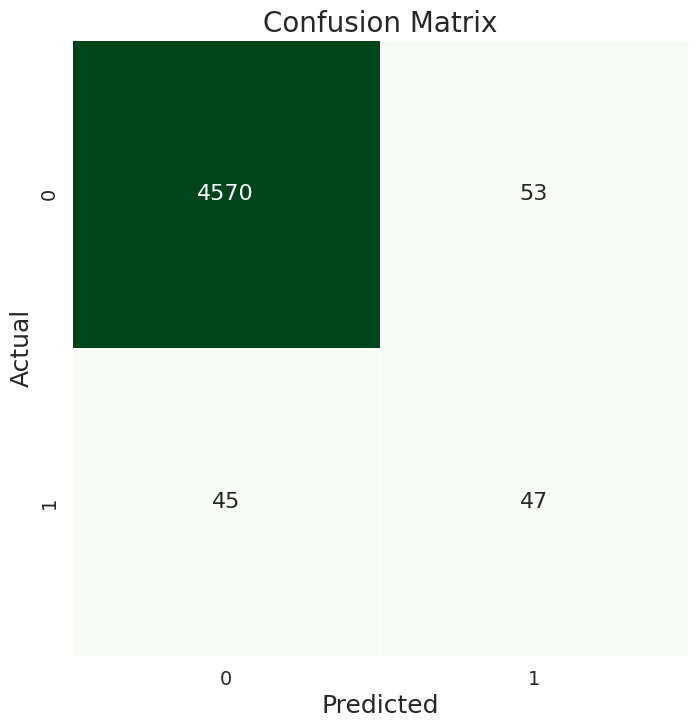

In [ ]:
y = [i.argmax() for i in actual_test_per_step['ensemble']]
pred = [i.argmax() for i in predictions_test_per_step['ensemble']]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart(cf_matrix_test, ocean + '_ensemble_cm_original')

In [ ]:
# Initialize lists to store precision, recall, and F1-score metrics for class 0, class 1, overall accuracy,
# macro average, and weighted average across multiple experiments
precision0 = []
precision1 = []
precisionacc = []
precisionmacavg = []
precisionweighavg = []
recall0 = []
recall1 = []
recallacc = []
recallmacavg = []
recallweighavg = []
f10 = []
f11 = []
f1acc = []
f1macavg = []
f1weighavg = []

# Loop through the results of multiple experiments
for i in range(No_exp):
    # Append precision, recall, and F1-score metrics for class 0, class 1, overall accuracy,
    # macro average, and weighted average from the 'vanilla' model results
    precision0.append(metrics_test_per_step['ensemble'][i]['0']['precision'])
    precision1.append(metrics_test_per_step['ensemble'][i]['1']['precision'])
    precisionacc.append(metrics_test_per_step['ensemble'][i]['accuracy'])
    precisionmacavg.append(metrics_test_per_step['ensemble'][i]['macro avg']['precision'])
    precisionweighavg.append(metrics_test_per_step['ensemble'][i]['weighted avg']['precision'])

    recall0.append(metrics_test_per_step['ensemble'][i]['0']['recall'])
    recall1.append(metrics_test_per_step['ensemble'][i]['1']['recall'])
    recallacc.append(metrics_test_per_step['ensemble'][i]['accuracy'])
    recallmacavg.append(metrics_test_per_step['ensemble'][i]['macro avg']['recall'])
    recallweighavg.append(metrics_test_per_step['ensemble'][i]['weighted avg']['recall'])

    f10.append(metrics_test_per_step['ensemble'][i]['0']['f1-score'])
    f11.append(metrics_test_per_step['ensemble'][i]['1']['f1-score'])
    f1acc.append(metrics_test_per_step['ensemble'][i]['accuracy'])
    f1macavg.append(metrics_test_per_step['ensemble'][i]['macro avg']['f1-score'])
    f1weighavg.append(metrics_test_per_step['ensemble'][i]['weighted avg']['f1-score'])



In [ ]:
print(str(round(np.mean(precision0),4)) + "±" + str(round(np.std(precision0),4))," & " + str(round(np.mean(recall0),4)) + "±" + str(round(np.std(recall0),4)), " & " + str(round(np.mean(f10),4)) + "±" + str(round(np.std(f10),4)))
print(str(round(np.mean(precision1),4)) + "±" + str(round(np.std(precision1),4))," & " + str(round(np.mean(recall1),4)) + "±" + str(round(np.std(recall1),4)), " & " + str(round(np.mean(f11),4)) + "±" + str(round(np.std(f11),4)))
print(str(round(np.mean(precisionacc),4)) + "±" + str(round(np.std(precisionacc),4))," & " + str(round(np.mean(recallacc),4)) + "±" + str(round(np.std(recallacc),4)), " & " + str(round(np.mean(f1acc),4)) + "±" + str(round(np.std(f1acc),4)))
print(str(round(np.mean(precisionmacavg),4)) + "±" + str(round(np.std(precisionmacavg),4))," & " + str(round(np.mean(recallmacavg),4)) + "±" + str(round(np.std(recallmacavg),4)), " & " + str(round(np.mean(f1macavg),4)) + "±" + str(round(np.std(f1macavg),4)))
print(str(round(np.mean(precisionweighavg),4)) + "±" + str(round(np.std(precisionweighavg),4))," & " + str(round(np.mean(recallweighavg),4)) + "±" + str(round(np.std(recallweighavg),4)), " & " + str(round(np.mean(f1weighavg),4)) + "±" + str(round(np.std(f1weighavg),4)))



0.9885±0.0011  & 0.9914±0.0028  & 0.99±0.0009
0.5074±0.0644  & 0.4196±0.0598  & 0.4519±0.0275
0.9803±0.0017  & 0.9803±0.0017  & 0.9803±0.0017
0.7479±0.0318  & 0.7055±0.0287  & 0.7209±0.0137
0.9791±0.0008  & 0.9803±0.0017  & 0.9795±0.0009
